In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM

device = 'cuda' if torch.cuda.is_available() else 'cpu'


from scipy.stats import bernoulli  
import matplotlib.pyplot as plt
import numpy as np

/home/dhanalaxmi/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Un-Normalization of GradCam

In [2]:
class GradCAM_un_norm(GradCAM):
        def forward(self, input, class_idx=None, retain_graph=False):
            b, c, h, w = input.size()

            logit = self.model_arch(input)
            if class_idx is None:
                score = logit[:, logit.max(1)[-1]].squeeze()
            else:
                score = logit[:, class_idx].squeeze()

            self.model_arch.zero_grad()
            score.backward(retain_graph=retain_graph)
            gradients = self.gradients['value']
            activations = self.activations['value']
            b, k, u, v = gradients.size()

            alpha = gradients.view(b, k, -1).mean(2)
            # alpha = F.relu(gradients.view(b, k, -1)).mean(2)
            weights = alpha.view(b, k, 1, 1)

            saliency_map = (weights*activations).sum(1, keepdim=True)
            saliency_map = F.relu(saliency_map)
            saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
            saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
            #saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
            saliency_map = saliency_map.data
    
            return saliency_map, logit

# CAMS

/home/dhanalaxmi/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


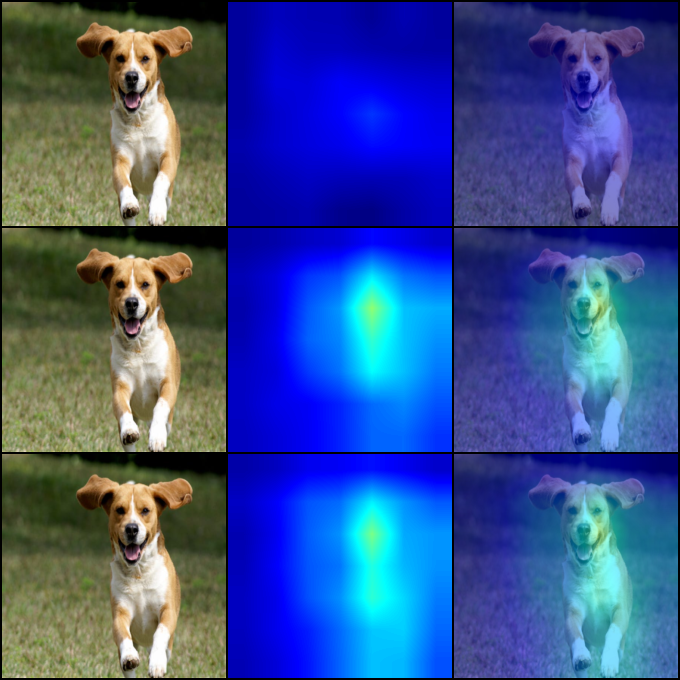

In [5]:
pil_img = PIL.Image.open('dog.jpg')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
resnet = models.resnet18(pretrained=True)
configs = [dict(model_type='resnet', arch=resnet, layer_name='layer4'),]

for config in configs:
    config['arch'].to(device).eval()

gradcam = GradCAM_un_norm.from_config(**config)
# gradcam = GradCAM.from_config(**config)

images = []
class_specific_maps = []
for i in range(262,265):
    mask, logits = gradcam(normed_torch_img, class_idx=i)
    class_specific_maps.extend([mask])
    heatmap, result = visualize_cam(mask, torch_img)    
    images.extend([torch_img.cpu(), heatmap, result])
    
grid_image = make_grid(images, nrow=3)
transforms.ToPILImage()(grid_image)

# Experiments on un normalizing mask

Concept:
The grad cam normalization converts all correct and uncorrect classes to a range of 0-1. 
This does not help in taking a class specific probability Ppeak and Ppatch.
The differences between classes can be better extracted from unormalized form.
The max value for the activations would be greater (eg:0.4) for a correct class compared to (eg.0.06) for uncorrect classes.

In [30]:
# Set gradcam to normalized and unormalized and verify results for correct classification
# gradcam = GradCAM_un_norm.from_config(**config)
mask.max(), mask.min()

(tensor(0.4914, device='cuda:0'), tensor(0.0399, device='cuda:0'))

In [32]:
# gradcam = GradCAM.from_config(**config) for correct class
mask.max(), mask.min()

(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))

In [35]:
# Set gradcam to normalized and unormalized and verify results for not correct classification
# gradcam = GradCAM_un_norm.from_config(**config)
mask.max(), mask.min()

(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))

In [39]:
# gradcam = GradCAM.from_config(**config) for not correct class
mask.max(), mask.min()

(tensor(0.0634, device='cuda:0'), tensor(0., device='cuda:0'))

# Model Prediction

In [7]:
# Model Prediction
output = resnet(normed_torch_img)
_, index = torch.max(output, 1)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
with open('imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
print('Index-', index.item(), labels[index[0]], percentage[index[0]].item())


Index- 264 Cardigan 26.327396392822266


Shape of incoming heatmap torch.Size([3, 224, 224])


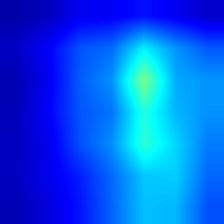

In [8]:
image = heatmap
print('Shape of incoming heatmap', image.shape)
grid_image = make_grid(heatmap, nrow=1)
transforms.ToPILImage()(grid_image)
# plt.title('Heatmap')


# Diversification Block

In [17]:
P_peak.item()


1

final Supression Mask Bc torch.Size([224, 224])


<ipython-input-20-5f10fdebd14f>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P_patch_ind = torch.nonzero(torch.tensor(P_patch)==1, as_tuple=False)


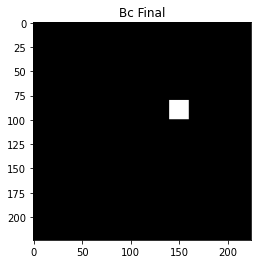

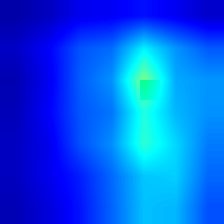

In [20]:
## Initializations
image = mask
# image = heatmap # Use this as image to visualize effect on heatmap
#squeeze for mask
image = image.squeeze(0)
rc = mask.max().item()  #should be 0 or 1 randomly for c classes
P_peak = bernoulli.rvs(rc,  size = 1)   # Bernoulli prob for P peak
C, M, N = image.shape
Bc = torch.zeros(M, N)

## Peak Suppression

# Peak Supression
max_ind = ((image == image.max()).nonzero(as_tuple=False))
Pc = Bc
Pc[max_ind[:, 0], max_ind[:, 1]] = 1
Bc_dash = P_peak.item() * Pc
Bc_dash.shape

## Patch Supression
# patching image to G*G patches
kernel_size = 20 #G
stride = kernel_size #G*G patch

image_tensor = image.unsqueeze(0) #adding dimension for batch
patches = image_tensor.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
num_patches = patches.shape[2]*patches.shape[3]
l, m = patches.shape[2], patches.shape[3]

# patching mask bc''(Bc_dd) to G*G patches (Bc_patch)
# Ppatch by probability of patch wise maximums
maxvals = torch.max(patches[0][0],3)
maxvals = torch.max(maxvals.values, 2)
P_patch = maxvals.values.cpu().apply_(lambda x: (bernoulli.rvs(x, size = 1)))
P_patch_ind = torch.nonzero(torch.tensor(P_patch)==1, as_tuple=False)
Bc_dd = Bc # Bc double dash allocating size with zeros
Bc_patch = Bc_dd.unsqueeze(0).unsqueeze(0).unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
# Bc_patch[0][0][P_patch_ind[:, 0]][P_patch_ind[:, 1]]=1 # Implementation of bc'' without for loop
Bc_patch[0][0] = 0
for i in range(len(P_patch_ind)):
    Bc_patch[0][0][P_patch_ind[i][0]][P_patch_ind[i][1]] = 1

# Bc_patch folding back Bc''(Bc_dd)
Bc_patch = (Bc_patch.reshape(1, 1, l, m, kernel_size*kernel_size)).permute(0, 1, 4, 2, 3).squeeze(0).squeeze(0)
Bc_patch = Bc_patch.view(kernel_size*kernel_size, -1)
Bc_dd = F.fold(Bc_patch.unsqueeze(0), (M, N), kernel_size=kernel_size, stride=stride)
Bc_dd = Bc_dd.squeeze(0).squeeze(0)

#Bc'' not supressing peak(peak=0)
Bc_dd[max_ind[:, 0], max_ind[:, 1]] = 0

# Final Supression Mask Bc
Bc = Bc_dash + Bc_dd
print('final Supression Mask Bc', Bc.shape)
plt.imshow(Bc, cmap='gray')
plt.title('Bc Final')
plt.show()

# Activation Supression Factor
Mc = image
alpha = 0.1
supress_ind = ((Bc == 1).nonzero(as_tuple=False))
Mc_dash = Mc
Mc_dash[0][supress_ind[:, 0], supress_ind[:, 1]] *= alpha


# diverse_block=[]
# diverse_block.extend([heatmap, Mc_dash])
grid_image = make_grid(Mc_dash.cpu(), nrow=1)
transforms.ToPILImage()(grid_image)
# plt.title('Heatmap')
# plt.show()


In [126]:
Mc_dash.shape

torch.Size([1, 224, 224])

# Ppatch by probality of Activation Map

In [ ]:
# patching mask bc''(Bc_dd) to G*G patches (Bc_patch)
a = 0.3
P_patch = bernoulli.rvs(a, size = (l,m)) #Bernoulli prob for P patch
P_patch_ind = torch.nonzero(torch.tensor(P_patch)==1, as_tuple=False)
Bc_dd = Bc # Bc double dash allocating size with zeros
Bc_patch = Bc_dd.unsqueeze(0).unsqueeze(0).unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
# Bc_patch[0][0][P_patch_ind[:, 0]][P_patch_ind[:, 1]]=1 # Implementation of bc'' without for loop
Bc_patch[0][0] = 0
for i in range(len(P_patch_ind)):
    Bc_patch[0][0][P_patch_ind[i][0]][P_patch_ind[i][1]] = 1
Bc_patch1 = Bc_patch #storing just for visualizing

## Visualization

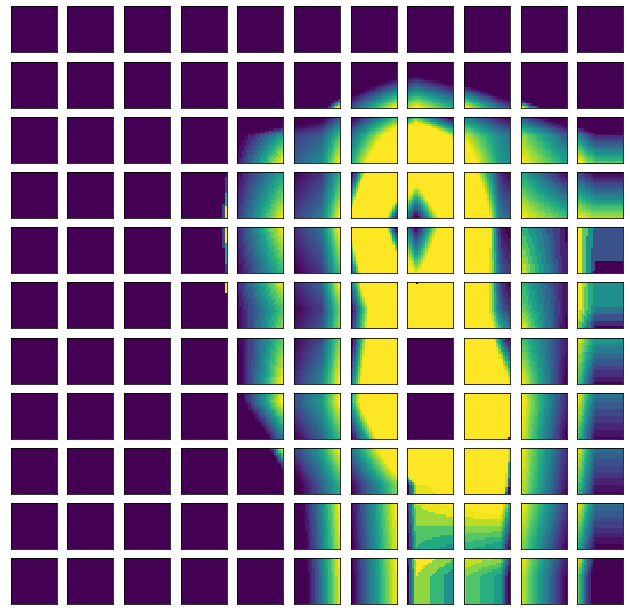

In [16]:
# Visualization
def visualize(patches, num_patches):
    """Imshow for Tensor.""" 
    a, b = patches.shape[2], patches.shape[3]
    fig = plt.figure(figsize=(a, b))
    num = a*b
    itern = 0
    while itern<num:
        for i in range(a):
            for j in range(b):
                itern += 1
                inp = patches[0][0][i][j]
                inp = np.array(inp)
                ax = fig.add_subplot(a, b, itern, xticks=[], yticks=[])
                plt.imshow(inp)
                
# patches[0][0][0][0] = 0
visualize(patches, num_patches)
